# Proportion of students who did not ever submitted assignments (released) per day 


In [31]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import json
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args

sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

term_19 = args.semester_2019_Spring
start_date_19 = args.start_date_2019_Spring
cutoff_date_19 = args.cutoff_date_2019_Spring
end_date_19 = args.end_date_2019_Spring

term_18 = args.semester_2018_Spring
start_date_18 = args.start_date_2018_Spring
cutoff_date_18 = args.cutoff_date_2018_Spring
end_date_18 = args.end_date_2018_Spring

term_17 = args.semester_2017_Spring
start_date_17 = args.start_date_2017_Spring
cutoff_date_17 = args.cutoff_date_2017_Spring
end_date_17 = args.end_date_2017_Spring

# load students
f = open('../user_id_groups.pkl', 'rb')
user = pickle.load(f)
students = user['student']


f = open('../assignment_with_submission.json',)
assignments_with_submission = json.load(f)['assignment_id']

In [32]:
enrollments = pd.read_csv(args.enrollments, header=0, sep='\t')
enrollments = enrollments.loc[(enrollments['user_id'].isin(students))&(enrollments['enrollment_role_type']=='StudentEnrollment')]

In [33]:
enrollments = enrollments[(enrollments['enrollment_state']=='active')|(enrollments['enrollment_state']=='completed')]
active_students = enrollments['user_id'].drop_duplicates().tolist()

In [34]:
def generate_roaster(enrollments, term):
    enrollments = enrollments.loc[enrollments['term_name']==term]
    course_group = enrollments.groupby('course_id')
    dic = dict()
    for i in course_group.groups.keys():
        student_ids = course_group.get_group(i)['user_id'].drop_duplicates().tolist()
        dic[i] = student_ids
    return dic

In [35]:
roaster_20 = generate_roaster(enrollments, term_20)
print(len(roaster_20))
roaster_19 = generate_roaster(enrollments, term_19)
print(len(roaster_19))
roaster_18 = generate_roaster(enrollments, term_18)
print(len(roaster_18))
roaster_17 = generate_roaster(enrollments, term_17)
print(len(roaster_17))

3693
3527
3410
3441


In [36]:
assignments = pd.read_csv(args.assignments, header=0, sep='\t')
assignments = assignments.loc[assignments['assignment_id'].isin(assignments_with_submission), ['course_id', 'assignment_id', 'asn_unlock_at']]
assignments_overrides = pd.read_csv(args.assignments_overrides, sep='\t', header=0)
assignments_overrides = assignments_overrides.loc[:, ['assignment_id', 'due_at', 'unlock_at']]
assignments = pd.merge(assignments, assignments_overrides, on='assignment_id', how='left')
#assignments['asn_unlock_at'] = assignments[['asn_unlock_at', 'unlock_at']].apply(lambda x: x['asn_unlock_at'] if pd.isnull(x['unlock_at']) else x['unlock_at'], axis=1)
assignments['asn_unlock_at'] = pd.to_datetime(assignments['asn_unlock_at'], format='%Y-%m-%d %H:%M:%S.%f')

submissions = pd.read_csv(args.submissions, header=0, sep='\t')
submissions = submissions.loc[submissions['user_id'].isin(active_students), ['submission_id', 'assignment_id', 'term_name', 'user_id', 'course_id']]
submissions_assign =  pd.merge(submissions, assignments, on=['course_id', 'assignment_id'], how='inner')
print(submissions_assign)

              submission_id      assignment_id    term_name  \
0         10720000075889535  10720000007777413  2017 Spring   
1         10720000071523675  10720000007777413  2017 Spring   
2         10720000071538097  10720000007777413  2017 Spring   
3         10720000075888973  10720000007777413  2017 Spring   
4         10720000071516379  10720000007777413  2017 Spring   
...                     ...                ...          ...   
31637242  10720000071918656  10720000007794996  2017 Spring   
31637243  10720000071919153  10720000007794996  2017 Spring   
31637244  10720000072323840  10720000007801529  2017 Spring   
31637245  10720000076058973  10720000007776811  2017 Spring   
31637246  10720000076058970  10720000007776785  2017 Spring   

                     user_id          course_id       asn_unlock_at due_at  \
0        -250648392945323941  10720000001458381                 NaT    NaN   
1        -536147747249938369  10720000001458381                 NaT    NaN   
2        

In [37]:
def submission_prop(submissions_assign, term, roaster, start_date, end_date):
    submission_term = submissions_assign.loc[(submissions_assign['term_name']==term)&(submissions_assign['asn_unlock_at'].notnull())]
    submission_term = submission_term.loc[(submission_term['asn_unlock_at']>=start_date)&(submission_term['asn_unlock_at']<=end_date)].drop_duplicates()
    submission_term = submission_term.loc[(submission_term['course_id'].isin(roaster.keys()))&(submission_term['user_id'].isin(active_students))]
    submission_term['asn_unlock_at'] = pd.to_datetime(submission_term['asn_unlock_at'], format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
    group = submission_term.groupby('asn_unlock_at')
    daily_rate = dict()
    for i in group.groups.keys():
        assign_day = group.get_group(i)
        course_assignment = assign_day.loc[:, ['course_id', 'assignment_id']].drop_duplicates()
        total_number = 0
        for j in course_assignment['course_id']:
            total_number += len(roaster[j])
            
        student_submission = assign_day.groupby(['course_id', 'assignment_id'])
        submission_number = 0
        for s in student_submission.groups.keys():
            submitted_students = student_submission.get_group(s)['user_id'].drop_duplicates().tolist()
            submission_number += len(set(submitted_students).intersection(set(roaster[s[0]])))
            
        rate = submission_number / total_number
        daily_rate[i] = [1-rate]
    
    rate_df = pd.DataFrame.from_dict(daily_rate, orient='index', columns=['rate'])
    return rate_df


In [38]:
rate_20 = submission_prop(submissions_assign, term_20, roaster_20, start_date_20, end_date_20)
#print(rate_20)
rate_19 = submission_prop(submissions_assign, term_19, roaster_19, start_date_19, end_date_19)
#print(rate_19)
rate_18 = submission_prop(submissions_assign, term_18, roaster_18, start_date_18, end_date_18)
#print(rate_18)
rate_17 = submission_prop(submissions_assign, term_17, roaster_17, start_date_17, end_date_17)
#print(rate_17)

In [39]:
rate_20 = rate_20.reset_index()
rate_19 = rate_19.reset_index()
rate_18 = rate_18.reset_index()
rate_17 = rate_17.reset_index()

rate_20.set_index('index', inplace=True)
rate_19['index'] = rate_19['index'].apply(lambda x: x.replace(year=2020))
rate_19.set_index('index', inplace=True)
rate_18['index'] = rate_18['index'].apply(lambda x: x.replace(year=2020))
rate_18.set_index('index', inplace=True)
rate_17['index'] = rate_17['index'].apply(lambda x: x.replace(year=2020))
rate_17.set_index('index', inplace=True)

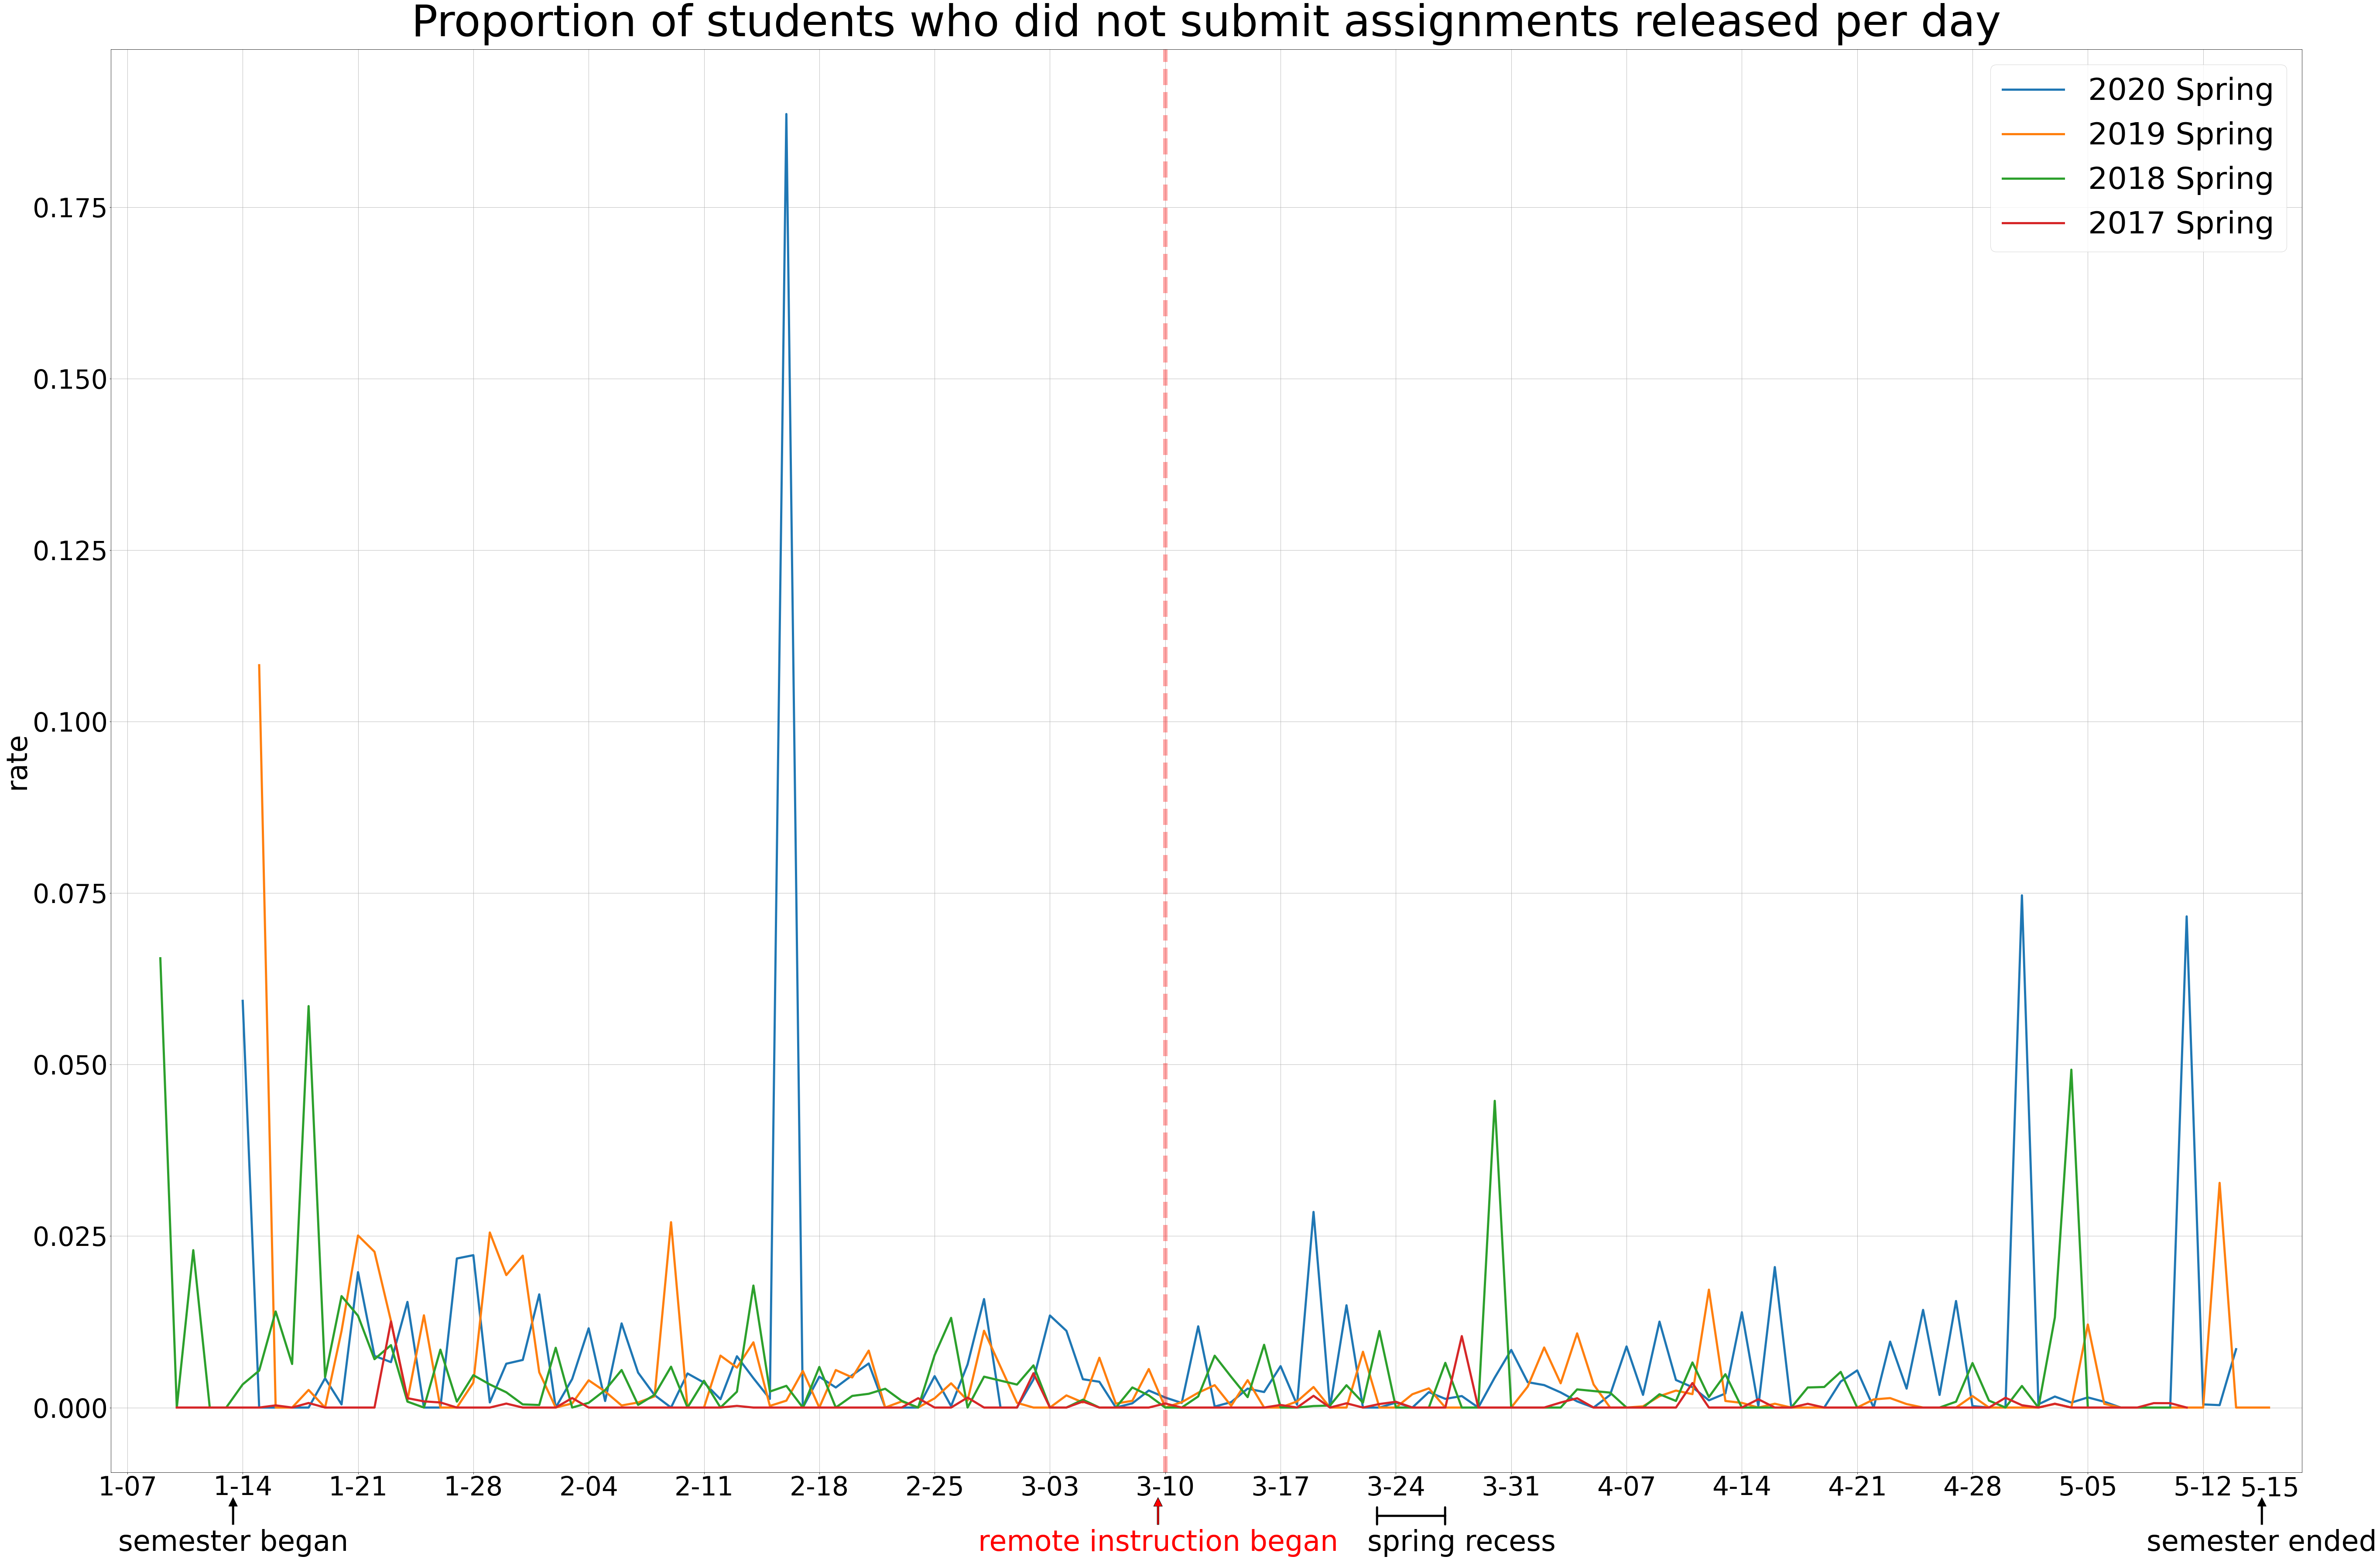

In [40]:
# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(rate_20, linewidth=5.0, label='2020 Spring')
plt.plot(rate_19, linewidth=5.0, label='2019 Spring')
plt.plot(rate_18, linewidth=5.0, label='2018 Spring')
plt.plot(rate_17, linewidth=5.0, label='2017 Spring')

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Proportion of students who did not submit assignments released per day', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('rate', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
plt.legend(prop={'size': 70})
plt.show()



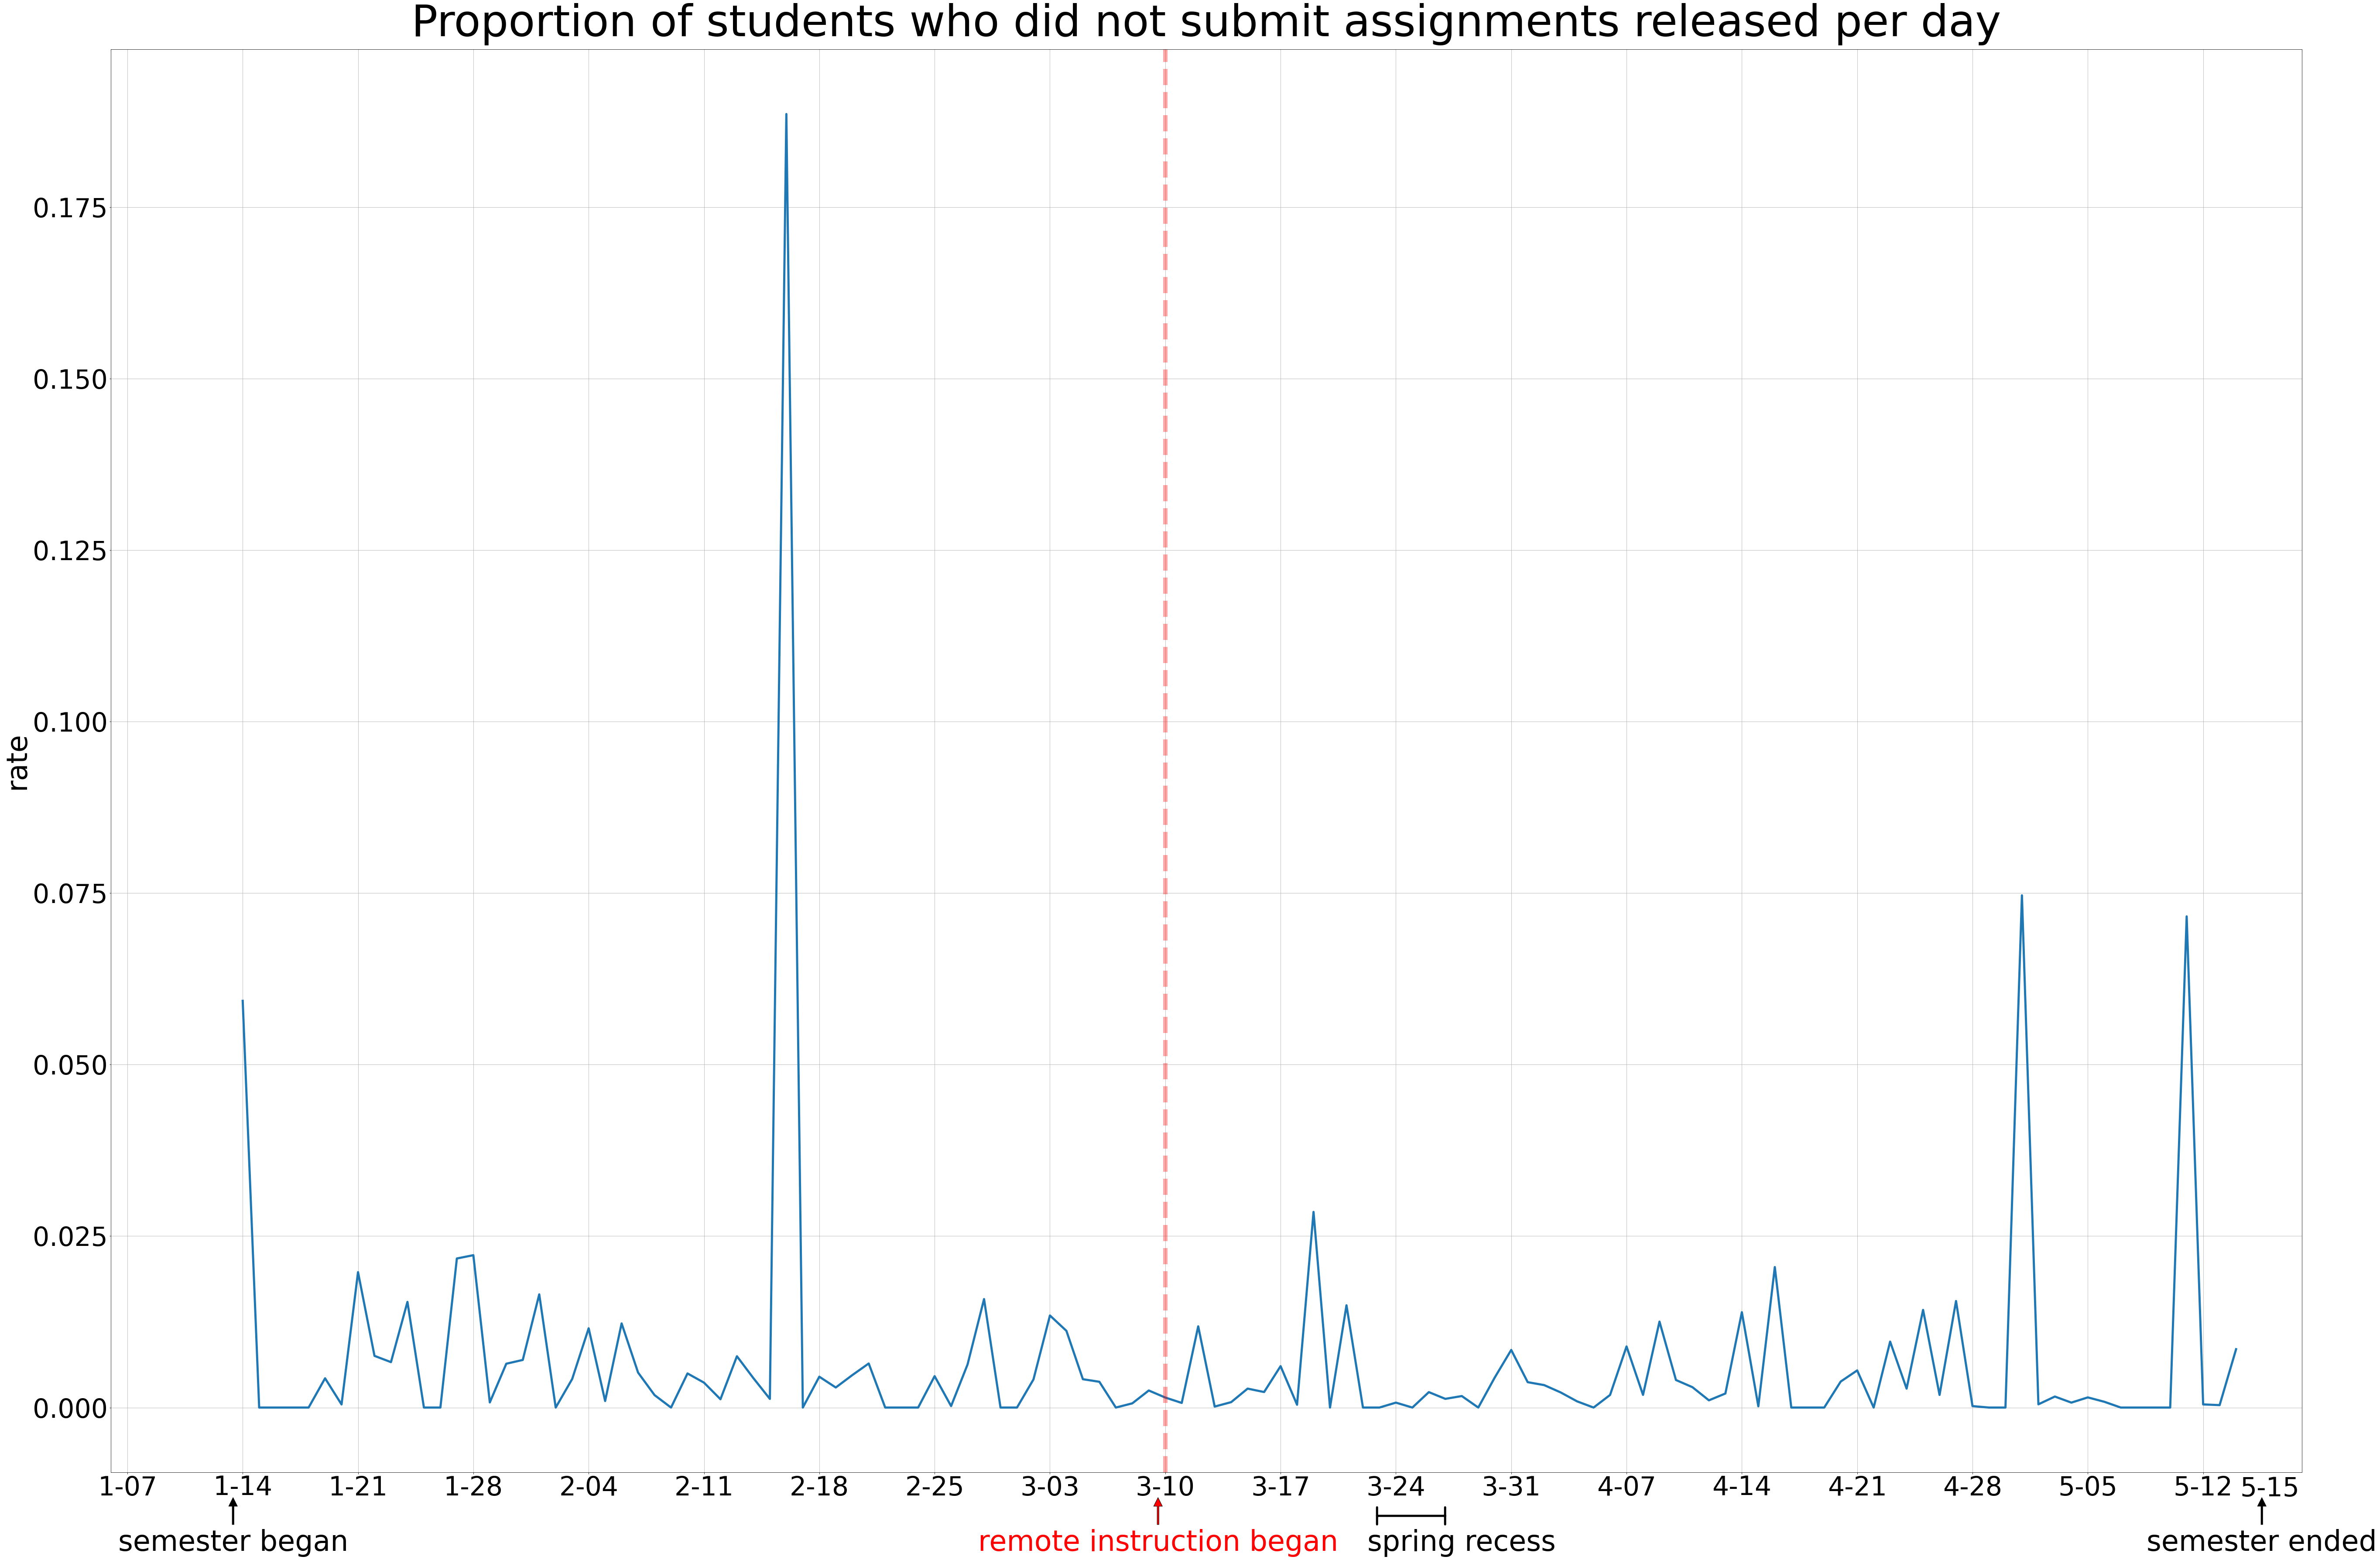

In [30]:
# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(rate_20, linewidth=5.0, label='2020 Spring')
plt.plot(rate_19, linewidth=5.0, label='2019 Spring', alpha=0)
plt.plot(rate_18, linewidth=5.0, label='2018 Spring', alpha=0)
plt.plot(rate_17, linewidth=5.0, label='2017 Spring', alpha=0)

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Proportion of students who did not submit assignments released per day', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('rate', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
#plt.legend(prop={'size': 70})
plt.show()



In [101]:
 # find TOP5 courses with the highest unsubmission rate on 2-16
def submission_prop(submissions_assign, term, roaster, start_date, end_date, check_date):
    submission_term = submissions_assign.loc[(submissions_assign['term_name']==term)&(submissions_assign['asn_unlock_at'].notnull())]
    submission_term = submission_term.loc[(submission_term['asn_unlock_at']>=start_date)&(submission_term['asn_unlock_at']<=end_date)].drop_duplicates()
    submission_term = submission_term.loc[(submission_term['course_id'].isin(roaster.keys()))&(submission_term['user_id'].isin(active_students))]
    submission_term['asn_unlock_at'] = pd.to_datetime(submission_term['asn_unlock_at'], format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
    assign_day = submission_term.loc[submission_term['asn_unlock_at']==check_date]
    student_submission = assign_day.groupby(['course_id', 'assignment_id'])
    rate_df = []
    for s in student_submission.groups.keys():
        submitted_students = student_submission.get_group(s)['user_id'].drop_duplicates().tolist()
        submission_rate = len(set(submitted_students).intersection(set(roaster[s[0]])))/len(roaster[s[0]])
        rate_df.append([s[0], submission_rate])
    rate_df = pd.DataFrame(rate_df, columns=['course', 'submission_rate'])
    rate_df = rate_df.sort_values(by='submission_rate')
    return rate_df

submission_rate_courses = submission_prop(submissions_assign, term_20, roaster_20, start_date_20, end_date_20, pd.to_datetime('2020-02-16', format='%Y-%m-%d'))
print(submission_rate_courses)



               course  submission_rate
4   10720000001490695         0.255708
14  10720000001492165         0.763158
0   10720000001487831         1.000000
1   10720000001487831         1.000000
2   10720000001488982         1.000000
3   10720000001489625         1.000000
5   10720000001490695         1.000000
6   10720000001490709         1.000000
7   10720000001490790         1.000000
8   10720000001490904         1.000000
9   10720000001491204         1.000000
10  10720000001491380         1.000000
11  10720000001491559         1.000000
12  10720000001491577         1.000000
13  10720000001491577         1.000000


In [103]:
courses = pd.read_csv(args.courses, header=0, sep='\t')
course = courses.loc[courses['canvas_global_course_id']==10720000001490695]
#print(course)
print(course.loc[:, ['canvas_course_name', 'course_code', 'sis_course_id']])
print(len(roaster_20[10720000001490695]))
course = courses.loc[courses['canvas_global_course_id']==10720000001492165]
print(course.loc[:, ['canvas_course_name', 'course_code', 'sis_course_id']])
print(len(roaster_20[10720000001492165]))

                                      canvas_course_name    course_code  \
25982  Introduction to Manufacturing and Tolerancing ...  Intro Mfg Tol   

             sis_course_id  
25982  CRS:ENGIN-27-2020-B  
219
         canvas_course_name           course_code  \
26297  PiE Mentorship Decal  PiE Mentorship Decal   

                       sis_course_id  
26297  CRS:ELENG-198-2020-B-E01C790C  
38
